# Esercitazione 7 - Simulazioni di dinamica molecolare con metodi Monte Carlo

## 1 Obiettivo

In questa esercitazione vengono simulati con metodi Monte Carlo sistemi di particelle interagenti mediante il potenziale di Lennard-Jones. Gli stessi sistemi erano stati studiati nel corso dell'esercitazione 4 con simulazioni basate sull'integrazione delle equazioni differenziali che governano il moto delle particelle.

Nella prima parte dell'esercitazione vengono discussi e affrontati alcuni problemi comuni ai metodi Monte Carlo ed in particolare alle implementazioni che sfruttano l'algoritmo di Metropolis per il campionamento.

Successivamente, dopo aver opportunamente modificato il codice fornitoci per soddisfare le richieste, vengono eseguite diverse simulazioni di sistemi in condizioni termodinamiche simili a quelli già studiati nell'esercitazione 4. In questo modo alcuni dei risultati ottenuti dai due diversi approci possono essere confrontati.

## 2 Cenni teorici e metodi utilizzati

Il sistema simulato è un ensemble NVT in cui il numero di molecole (N), il volume del sistema isolato (V) e la temperatura (T) sono fissati.

Un sistema di questo tipo può assumere diversi stati $\Psi$ caratterizzati ciascuno da energia potenziale $E_\Psi$. Dalla meccanica statistica è noto che la probabilità che il sistema si trovi nello stato $\Psi$ generico è proporzionale al fattore di Boltzmann

$$
P_\Psi \propto \exp(-\frac{E_\Psi}{k_BT})
$$

a cui va aggiunta una costante di normalizzazione che risulta però non necessaria se si campiona questa distribuzione di probabilità con l'algoritmo di Metropolis.

Nel corso della simulazione vengono effettuate misure delle seguenti grandezze fisiche:
- energia potenziale media per molecola (U/N)
- pressione (P)
- funzione di distribuzione radiale g(r)

La pressione viene stimata utilizzando la seguente relazione ricavata sfruttando il teorema del viriale

$$ P = \rho k_B T + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48\epsilon \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle $$

La funzione di distribuzione radiale fornisce la probabilità di osservare una coppia di atomi distanti $r$ relativamente alla probabilità aspettata per una distribuzione completamente casuale caratterizzata dalla stessa densità. Per poterla stimare nella pratica è necessario discretizzarla. La relazione utilizzata nell'implementazione è la seguente

$$
g(r) = \frac{1}{\rho N\Delta V(r)}\langle \sum_{i=1}^N \sum_{j=1}^N \delta[|\vec r| - |(\vec r_i - \vec r_j)|]\rangle
$$

In pratica questa relazione richiede, per la stima di g(r), di riempire un istogramma aumentando di 2 (se i cicli sono fatti in modo da iterare su ciascuna coppia di particelle una sola volta) il bin relativo a $r$ ogni volta che si trova una coppia di particelle a distanza tra $r$ e $r+dr$. Infine sarà necessario dividere per il fattore presente nella formula.

Il potenziale di interazione tra le particelle è il potenziale di Lenneard-Jones 

$$
V(r) = 4\epsilon[(\sigma/r)^{12}-(\sigma/r)^6]
$$

in questa simulazione viene applicato un cut-off sferico al potenziale. Vale a dire che le particelle a distanza $r>r_c$ vengono considerate non interagenti. $r_c$ è un parametro della simulazione. Viene però aggiunta una correzione a tutte le misure chiamata "correzione di coda" consistente nel contributo stimato alle varie grandezze fisiche dovuto dall'interazione con le particelle a distanza $r>r_c$. Per stimare questo contributo si assume $g(r)\sim1$ nella regione $r>r_c$ che corrisponde all'approsimare la distribuzione delle particelle con una distribuzione completamente casuale con la medesima densità.

## 3 Implementazione

Il codice utilizzato ha la seguente struttura
- inizializzazione
- ciclo sui blocchi, per ogni blocco si eseguono:
    * ciclo sugli step del blocco, ogni step consiste in:
        + esecuzione di uno step dell'algoritmo
        + esecuzione delle misure
        + accumulo delle misure
    * calcolo e output delle medie di blocco
- salvatagguio della configurazione finale

Nella fase di inizializzazione vengono letti i parametri in input dal file `input.dat`, vengono inzializzate le variabili poi usate durante la simulazione e viene letta la configurazione iniziale dal file `config.io`. Vengono inoltre calcolate le correzioni di coda per le grandezze fisiche che verranno misurate.

Il resto del programma è strutturato, come ho indicato, in blocchi di step con richiami a particolari funzioni che eseguono le misure sul sistema e calcolano le medie di blocco. Questa struttura è utilizzata per implementare l'algoritmo della media a blocchi sulle misure che vengono effettuate.

Ciascuno step dell'algoritmo corrisponde ad una chiamata alla funzione `Move()` che esegue un numero di step Monte Carlo pari al numero di particelle del sistema. In questo modo mediamente ogni particella ha avuto l'opportunità di cambiare posizione.
Un singolo step Monte Carlo consiste nei seguenti passaggi:
- viene estratta casualmente una particella del sistema
- viene proposto lo spostamento di questa particella in una nuova posizione, estraendo le nuove coordinate con probabilità uniforme lungo ciascuno dei tre assi entro una distanza pari a `delta`/2 dalla rispettiva coordinata della posizione corrente
- viene calcolata l'energia associata alla configurazione corrente e alla nuova configurazione proposta
- la mossa proposta viene accettata con la probabilità di accettazione data dall'algoritmo di Metropolis. Avendo scelto una funzione di transizione simmetrica questa è data da

$$
P_{acc} = \text{min}[1, p(E_{new})/p(E_{old}] = \text{min}[1, \exp(\frac{E_{old}-E_{new}}{k_BT})]
$$

- se la mossa viene rifiutata viene mantenuta la configurazione precedente come nuova configurazione

Il parametro `delta` è stato regolato nelle diverse simulazioni in modo tale da ottenere un rapporto di accettazione del 50% circa.

## 4 Utilizzo

Il programma non richiede nessun argomento per essere eseguito. 
I parametri della simulazione vengono letti dal file `io/input.dat`. Tramite di esso è possibile impostare, in quest'ordine:
- la temperatura del sistema 
- il numero di particelle
- la densità
- la distanza massima a cui due particelle vengono considerate interagenti
- il `delta` parametro della funzione di transizione dell'algoritmo di Metropolis
- il numero di blocchi in cui dividere le misure
- il numero  di step, ovvero chiamate alla funzione `Move()`, per blocco

La configurazione iniziale viene letta dal file `config.0`. 

Tutti i file di output vengono creati nella directory `io` e presentano il seguente contenuto:
  * `output.instant.<property>.0`: contiene tutte le misure eseguite di `<property>`
  * `output.<property>.0`: ogni riga contiene, nel seguente ordine
      - numero `i` del blocco
      - media di blocco
      - media delle medie di blocco da `0` a `i`
      - incertezza statistica
      
    fanno eccezione i file `output.gofr.0`  e `output.gave.0`. Entrambi contengono le misure di g(r) con un formato a colonne in cui sono contenuti nell'ordine i seguenti valori: r, g(r), incertezza su g(r). Essendo g(r) misurato come un istogramma, il valore di r corrisponde al valore medio del bin corrispondente. Nel file `.gave.` è contenuto il risultato finale ottenuto dalla media a blocchi mentre nel file `.gofr.` sono contenuti i risultati ottenuti ad ogni blocco considerando solo i blocchi precedenti.
  * `config.final`: configurazione al tempo finale $t$
  
Decommentando una specifica riga del codice è anche possibile ricompilare il programma in modo che durante la sua esecuzione salvi nel formato .xyz alcune delle configurazioni del sistema.

## 5 Unità ridotte

Tutte le grandezze fisiche considerate nella simulazione sono espresse in unità ridotte:
- $T^\star = k_BT/\epsilon$
- $V^\star = V/\epsilon$
- $K^\star = K/\epsilon$
- $E^\star = E/\epsilon$
- $P^\star = P\sigma^3/\epsilon$
- $\rho^\star = \rho\sigma^3$

$\epsilon$ e $\sigma$ sono i parametri che caratterizzano il potenziale di Lennard-Jones.
Le seguenti funzioni implementano la conversione da unità ridotte a unità del sistema internazionale, i valori di default impostati per $\epsilon$, $\sigma$ e m sono quelli utilizzati nelle simulazioni che seguono.

In [1]:
import scipy.constants as cc

uma = cc.physical_constants['atomic mass constant'][0]

def CUtoSI_energy(value, epsilon=120*cc.k):
    return value*epsilon

def CUtoSI_temperature(value, epsilon=120*cc.k):
    return value*epsilon/cc.k

def CUtoSI_density(value, sigma=0.34e-9, m=39.948*uma):
    return m*value/(sigma**3)

def CUtoSI_pressure(value, sigma=0.34e-9, epsilon=120*cc.k):
    return value*epsilon/(sigma**3)

def CUtoSI_length(value, sigma=0.34e-9):
    return value*sigma

## 6 Equilibrazione

Ho innanzitutto eseguito delle simulazini in ciascuna delle seguenti condizioni:
- fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$  (raggio di cut-off: $r_c = 2.2$)
- fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$  (raggio di cut-off: $r_c = 2.5$)
- fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c = 5.0$)

In queste simulazioni sono stati eseguiti 50000 step. Nei grafici seguenti sono rappresentati i valori istantanei di alcune grandezze fisiche misurate. È stato inoltre eseguito a destra di ciascuna figura un ingrandimento in cui è possibile apprezzare la fase iniziale di equilibrazione.

Per equilibrare le successive simulazioni ho sfruttato la possibilità del programma realizzato di ripartire da una configurazione precedentemente salvata. Le configurazioni finali di queste simulazioni di equilibrazione sono quindi state usate come punto di partenza per le successive simulazioni effettuate nelle medesime condizioni termodinamiche.

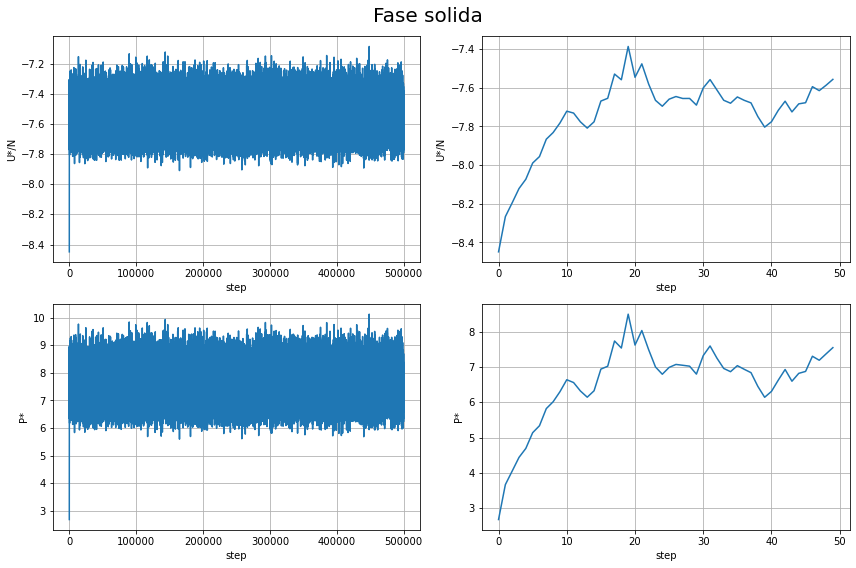

In [2]:
from IPython.display import display, Latex
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

file_in = ['output.instant.epot.0', 'output.instant.pres.0']
labely = ['U*/N', 'P*']
titles = ['Energia potenziale', 'Pressione']

instdata_sol = [
    np.loadtxt('../07/MonteCarlo_NVT/eqSolid/' + file , usecols=(0), delimiter=" ", unpack=True) for file in file_in
]

fig, plots = plt.subplots(2,2)
fig.set_size_inches(12, 8)
for i in range(0, 2):
    x = np.arange(0, len(instdata_sol[i]))
    plots[i][0].set(xlabel='step', ylabel=labely[i])
    plots[i][0].grid()
    plots[i][0].plot(x, instdata_sol[i])
    plots[i][1].set(xlabel='step', ylabel=labely[i])
    plots[i][1].grid()
    plots[i][1].plot(x[0:50], instdata_sol[i][0:50])
    
plt.suptitle('Fase solida', fontsize='20')
plt.tight_layout()
plt.show()


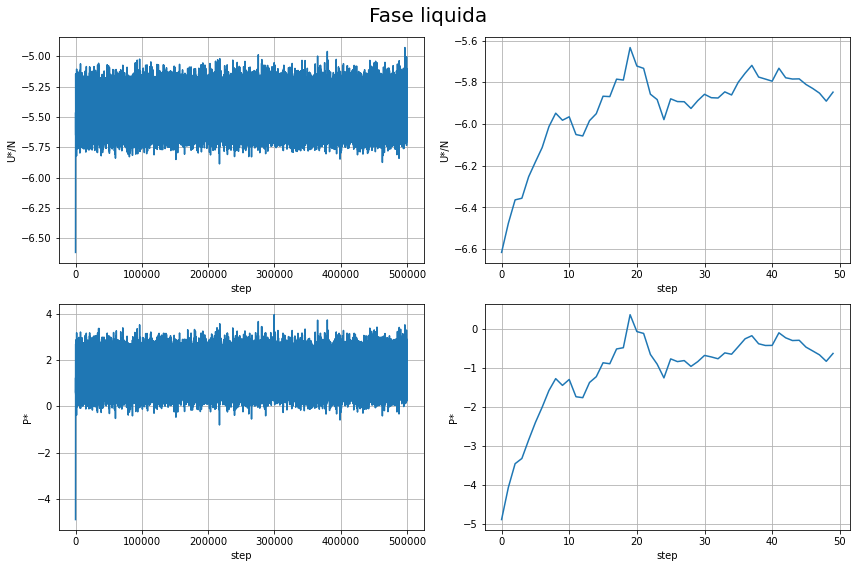

In [3]:
instdata_liq = [
    np.loadtxt('../07/MonteCarlo_NVT/eqLiquid/' + file , usecols=(0), delimiter=" ", unpack=True) for file in file_in
]

fig, plots = plt.subplots(2,2)
fig.set_size_inches(12, 8)
for i in range(0, 2):
    x = np.arange(0, len(instdata_liq[i]))
    plots[i][0].set(xlabel='step', ylabel=labely[i])
    plots[i][0].grid()
    plots[i][0].plot(x, instdata_liq[i])
    plots[i][1].set(xlabel='step', ylabel=labely[i])
    plots[i][1].grid()
    plots[i][1].plot(x[0:50], instdata_liq[i][0:50])
    
plt.suptitle('Fase liquida', fontsize='20')
plt.tight_layout()
plt.show()


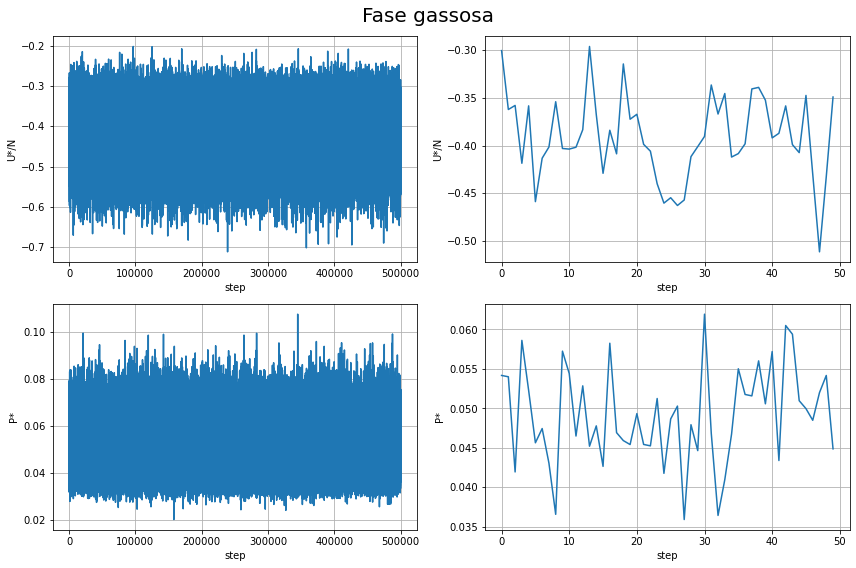

In [4]:
instdata_gas = [
    np.loadtxt('../07/MonteCarlo_NVT/eqGas/' + file , usecols=(0), delimiter=" ", unpack=True) for file in file_in
]

fig, plots = plt.subplots(2,2)
fig.set_size_inches(12, 8)
for i in range(0, 2):
    x = np.arange(0, len(instdata_gas[i]))
    plots[i][0].set(xlabel='step', ylabel=labely[i])
    plots[i][0].grid()
    plots[i][0].plot(x, instdata_gas[i])
    plots[i][1].set(xlabel='step', ylabel=labely[i])
    plots[i][1].grid()
    plots[i][1].plot(x[0:50], instdata_gas[i][0:50])
    
plt.suptitle('Fase gassosa', fontsize='20')
plt.tight_layout()
plt.show()


Le simulazioni già equilibrate ottenute partendo dalle configurazioni finali delle simulazioni precedenti, hanno prodotto le seguenti misure istantanee

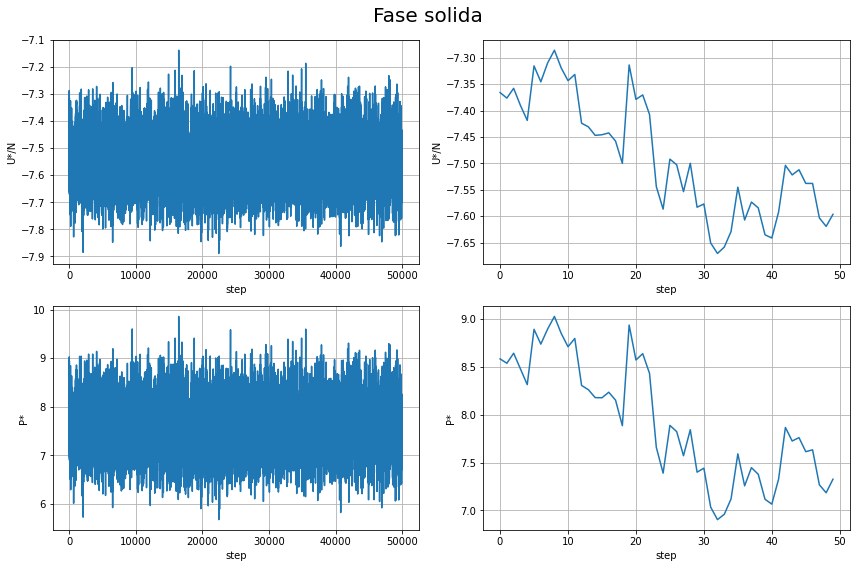

In [5]:
instdata_sol = [
    np.loadtxt('../07/MonteCarlo_NVT/instSolid/' + file , usecols=(0), delimiter=" ", unpack=True) for file in file_in
]

fig, plots = plt.subplots(2,2)
fig.set_size_inches(12, 8)
for i in range(0, 2):
    x = np.arange(0, len(instdata_sol[i]))
    plots[i][0].set(xlabel='step', ylabel=labely[i])
    plots[i][0].grid()
    plots[i][0].plot(x, instdata_sol[i])
    plots[i][1].set(xlabel='step', ylabel=labely[i])
    plots[i][1].grid()
    plots[i][1].plot(x[0:50], instdata_sol[i][0:50])
    
plt.suptitle('Fase solida', fontsize='20')
plt.tight_layout()
plt.show()

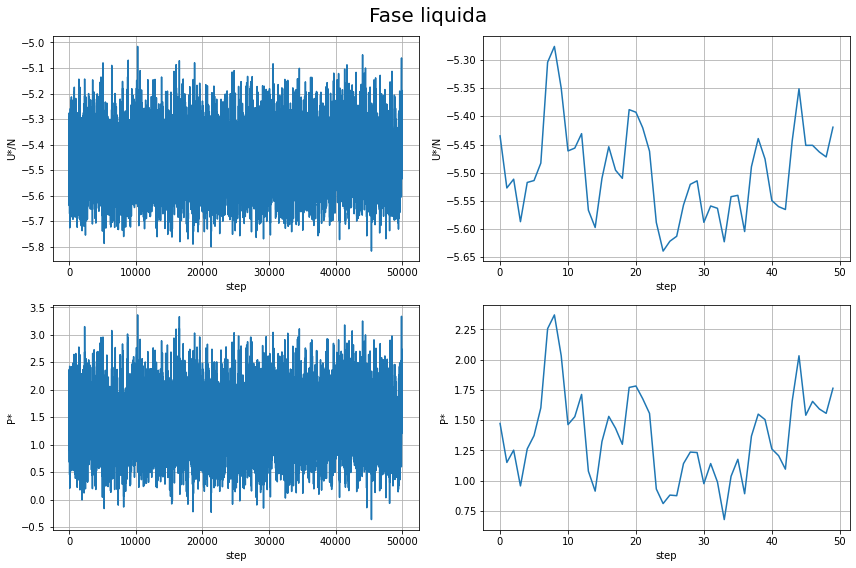

In [6]:
instdata_liq = [
    np.loadtxt('../07/MonteCarlo_NVT/instLiquid/' + file , usecols=(0), delimiter=" ", unpack=True) for file in file_in
]

fig, plots = plt.subplots(2,2)
fig.set_size_inches(12, 8)
for i in range(0, 2):
    x = np.arange(0, len(instdata_liq[i]))
    plots[i][0].set(xlabel='step', ylabel=labely[i])
    plots[i][0].grid()
    plots[i][0].plot(x, instdata_liq[i])
    plots[i][1].set(xlabel='step', ylabel=labely[i])
    plots[i][1].grid()
    plots[i][1].plot(x[0:50], instdata_liq[i][0:50])
    
plt.suptitle('Fase liquida', fontsize='20')
plt.tight_layout()
plt.show()

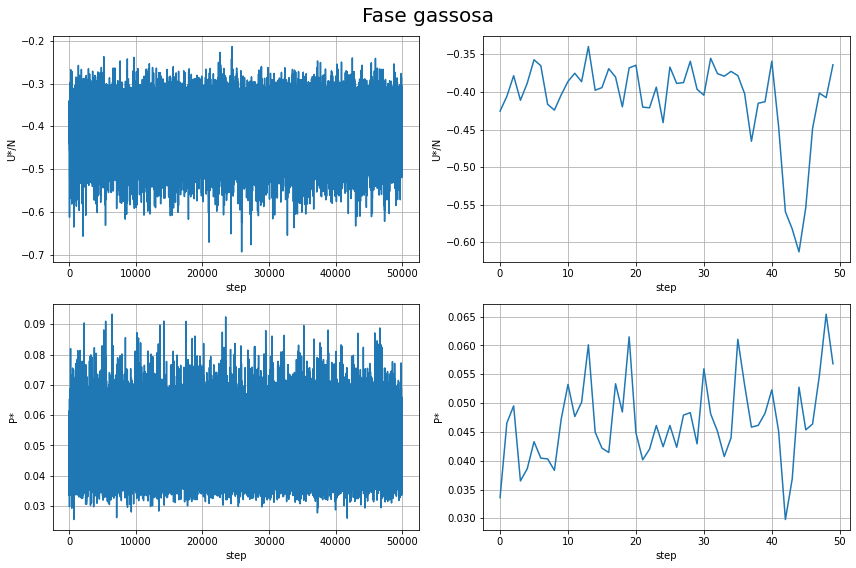

In [7]:
instdata_gas = [
    np.loadtxt('../07/MonteCarlo_NVT/instGas/' + file , usecols=(0), delimiter=" ", unpack=True) for file in file_in
]

fig, plots = plt.subplots(2,2)
fig.set_size_inches(12, 8)
for i in range(0, 2):
    x = np.arange(0, len(instdata_gas[i]))
    plots[i][0].set(xlabel='step', ylabel=labely[i])
    plots[i][0].grid()
    plots[i][0].plot(x, instdata_gas[i])
    plots[i][1].set(xlabel='step', ylabel=labely[i])
    plots[i][1].grid()
    plots[i][1].plot(x[0:50], instdata_gas[i][0:50])
    
plt.suptitle('Fase gassosa', fontsize='20')
plt.tight_layout()
plt.show()


Si osservi in questi grafici come ora le misure istantanee eseguite nei primi step della simulazione presentino fluttuazioni nello stesso intervallo di valori assunti durante tutti gli step successivi. Questi grafici mostrano quindi come l'equilibrazione sia avvenuta in maniera efficace.

## 7 Scelta della dimensione dei blocchi

In questa e in altre esercitazioni è stato usato l'algoritmo della media a blocchi per trattare le misure ottenute durante le simulazioni. Lo scopo di questo approcio è duplice: permette di fornire una incertezza statistica sui valori medi ottenuti e rimuove l'effetto di correlazioni tra successivi step dell'algoritmo di Metropolis. 
Affinchè entrambi questi obiettivi siano correttamente raggiunti è necessario scegliere correttamente la dimensione dei blocchi utilizzati. 
In questo paragrafo verrà affrontato questo problema.

### 7.1 Autocorrelazione delle misure

Coi dati dei grafici precedenti, quelli ottenuti da simulazioni equilibrate, ho calcolato l'autocorrelazione delle sequenze di misure istantanee considerando ciascuno step come un diverso istante dell'intervallo di tempo discretizzato della simulazione. La seguente formula è stata implementata nella funzione successiva

$$
\chi(t) = \frac
{
    \frac{1}{t_{max}-t} \sum_{t'=0}^{t_{max}-t}m(t')m(t'+t) - \frac{1}{t_{max}-t} \sum_{t'=0}^{t_{max}-t}m(t')\cdot\frac{1}{t_{max}-t}  \sum_{t'=0}^{t_{max}-t}m(t'+t)
}{
\frac{1}{t_{max}}  \sum_{t'=0}^{t_{max}}m^2(t') - \left( \frac{1}{t_{max}} \sum_{t'=0}^{t_{max}}m(t') \right) ^2
}
$$

dove $m(t)$ indica la misura della grandezza fisica di cui si sta valutando l'autocorrelazione, effettuata allo step che rappresenta il tempo $t$.

I risultati ottenuti, per le misure di energia potenziale e pressione e nei tre stati fisici, sono le seguenti.

In [8]:
def my_autocorr(data):
    tmax = len(data)
    auto_corr = np.zeros(tmax)
    for t in range(0, len(data)):
        mm = 0.0
        for i in range(0, tmax-t):
            mm += data[i]*data[i+t]
        mm /= float(tmax-t)
        smsm = np.sum(data[0:tmax-t])*np.sum(data[t:tmax])/(float(tmax-t)**2)
        den = np.sum(np.power(data,2))/float(tmax) - (np.sum(data)/tmax)**2
        auto_corr[t] = (mm-smsm)/den
    return auto_corr

In [9]:
%%time
acorr_sol = [my_autocorr(data[0:10000]) for data in instdata_sol]
acorr_liq = [my_autocorr(data[0:10000]) for data in instdata_liq]
acorr_gas = [my_autocorr(data[0:10000]) for data in instdata_gas]

CPU times: user 1min 53s, sys: 57.4 ms, total: 1min 54s
Wall time: 1min 54s


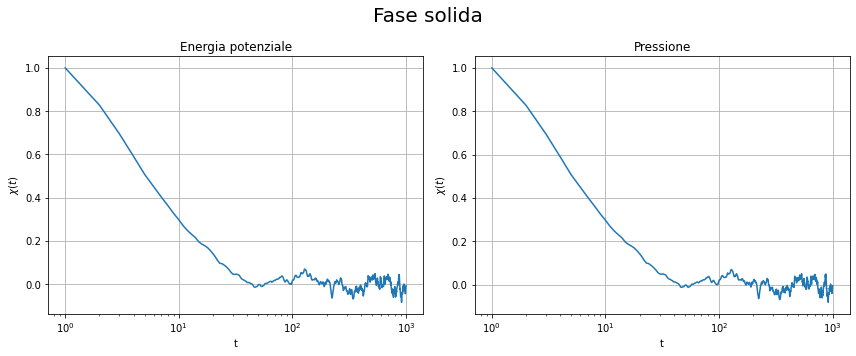

In [10]:
sub_titles = ['Energia potenziale', 'Pressione']
fig, plots = plt.subplots(1,2)
fig.set_size_inches(12, 5)
for i in range(0, 2):
    t = np.arange(1, len(acorr_sol[i]))
    plots[i].set(xlabel='t', ylabel='$\chi(t)$')
    plots[i].grid()
    plots[i].plot(t[0:1000], acorr_sol[i][0:1000])
    plots[i].set_xscale('log')
    plots[i].set_title(sub_titles[i])
plt.suptitle('Fase solida', fontsize='20')
plt.tight_layout()
plt.show()

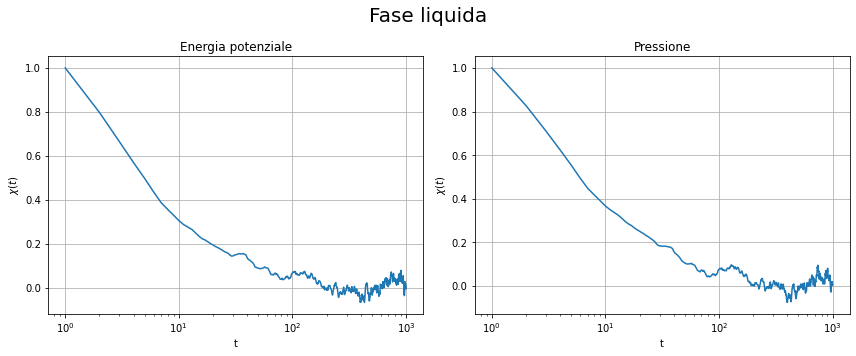

In [11]:
sub_titles = ['Energia potenziale', 'Pressione']
fig, plots = plt.subplots(1,2)
fig.set_size_inches(12, 5)
for i in range(0, 2):
    t = np.arange(1, len(acorr_liq[i]))
    plots[i].set(xlabel='t', ylabel='$\chi(t)$')
    plots[i].grid()
    plots[i].plot(t[0:1000], acorr_liq[i][0:1000])
    plots[i].set_xscale('log')
    plots[i].set_title(sub_titles[i])
plt.suptitle('Fase liquida', fontsize='20')
plt.tight_layout()
plt.show()

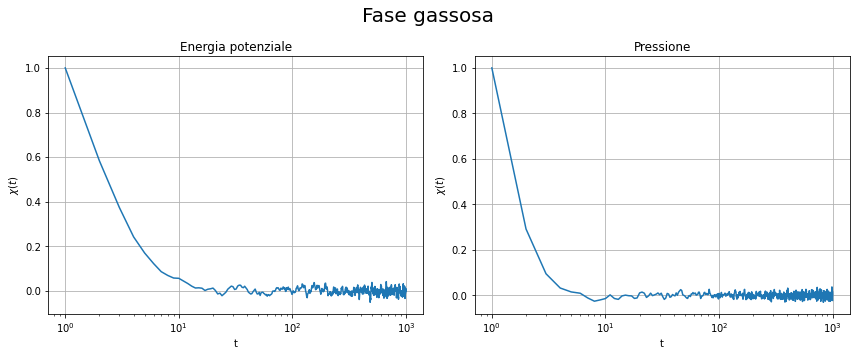

In [12]:
sub_titles = ['Energia potenziale', 'Pressione']
fig, plots = plt.subplots(1,2)
fig.set_size_inches(12, 5)
for i in range(0, 2):
    t = np.arange(1, len(acorr_gas[i]))
    plots[i].set(xlabel='t', ylabel='$\chi(t)$')
    plots[i].grid()
    plots[i].plot(t[0:1000], acorr_gas[i][0:1000])
    plots[i].set_xscale('log')
    plots[i].set_title(sub_titles[i])
plt.suptitle('Fase gassosa', fontsize='20')
plt.tight_layout()
plt.show()

Nei grafici ottenuti per lo stato solido e liquido, si può osservare un valore iniziale alto di autocorrelazione che raggiunge lo zero dopo circa 100 step. Si può concludere che approssimativamente il tempo di correlazione delle misure ottenute nelle simulazioni è di circa 100 step. Lo stato gassoso mostra un tempo di correlazione minore. L'algoritmo della media a blocchi richiede la scelta di blocchi sufficientemente grandi da essere tra loro scorrelati. La scelta di una dimensione pari a qualche volta il tempo di correlazione garantisce questa ipotesi.

Questo test impone quindi di scegliere blocchi di dimensione maggiore di qualche centinaio di step.

### 7.2 Variabilità dell'errore

In questo paragrafo ho utilizzato gli stessi dati precedenti per esplorare ora l'effetto della dimensione dei blocchi sulle incertezze statistiche che si ottengono con l'algoritmo della media a blocchi.

Il codice in python che segue divide iterativamente le N misure in M blocchi distinti da L = N/M misure ciascuno. Con questi blocchi viene poi applicato l'algoritmo della media a blocchi calcolando le medie di blocco e quindi la media delle medie di blocco e l'incertezza statistica stimata con la deviazione standard delle medie.

I grafici mostrano quindi, per i tre stati e per le due grandezze fisiche misurate, a sinistra i valori medi finali ottenuti in funzione di L e a destra la variazione dell'incertezza statistica in funzione di L.

In [13]:
#solido
def err(means):
    means2 = np.power(means, 2)
    n = len(means)
    if n==1:
        return 0
    else:
        return np.sqrt((np.mean(means2)-(np.mean(means))**2)/(n-1))

def do_block_ave(data, list_of_L):
    L = list_of_L
    n = len(data)
    means = np.zeros(len(L))
    errs = np.zeros(len(L))
    for l in L:
        blocks = [data[l*i:l*(i+1)] for i in range(0,int(n/l))]
        blk_m = [np.mean(block) for block in blocks]
        means[L.index(l)] = np.mean(blk_m)
        errs[L.index(l)] = err(blk_m)
    return {'means': means, 'errs':errs}

In [14]:
%%time
list_of_L = range(1,5000,10)
ris_sol = [do_block_ave(data, list_of_L) for data in instdata_sol]
ris_liq = [do_block_ave(data, list_of_L) for data in instdata_liq]
ris_gas = [do_block_ave(data, list_of_L) for data in instdata_gas]

CPU times: user 4.3 s, sys: 13.3 ms, total: 4.31 s
Wall time: 4.33 s


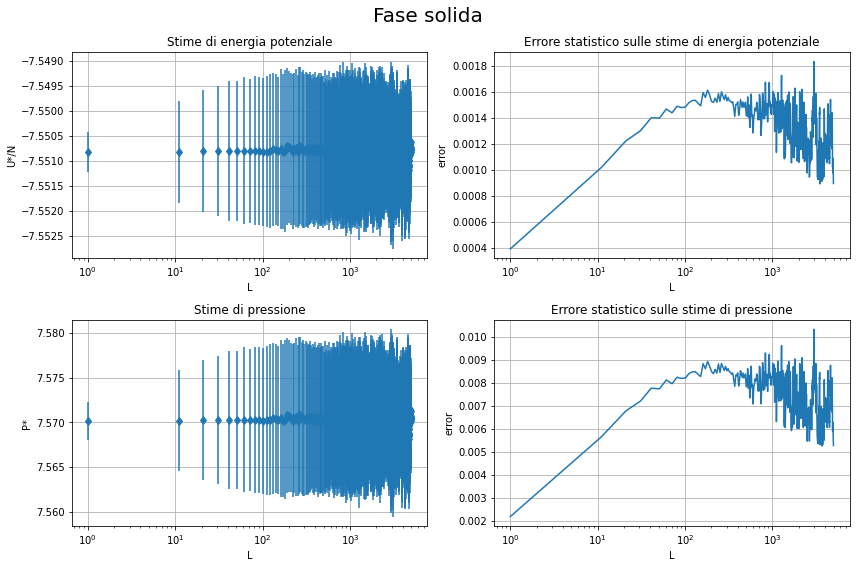

In [15]:
fig, plots = plt.subplots(2,2)
fig.set_size_inches(12, 8)

sub_tit_part = ['energia potenziale', 'pressione']
for i in range(0, 2):
    plots[i][0].set(xlabel='L', ylabel=labely[i])
    plots[i][0].grid()
    plots[i][0].errorbar(list_of_L, ris_sol[i]['means'], ris_sol[i]['errs'], fmt='d')
    plots[i][0].set_xscale('log')
    plots[i][0].set_title('Stime di ' + sub_tit_part[i])
    plots[i][1].set(xlabel='L', ylabel='error')
    plots[i][1].grid()
    plots[i][1].set_xscale('log')
    plots[i][1].plot(list_of_L, ris_sol[i]['errs'])
    plots[i][1].set_title('Errore statistico sulle stime di ' + sub_tit_part[i])
    
plt.suptitle('Fase solida', fontsize='20')
plt.tight_layout()
plt.show()

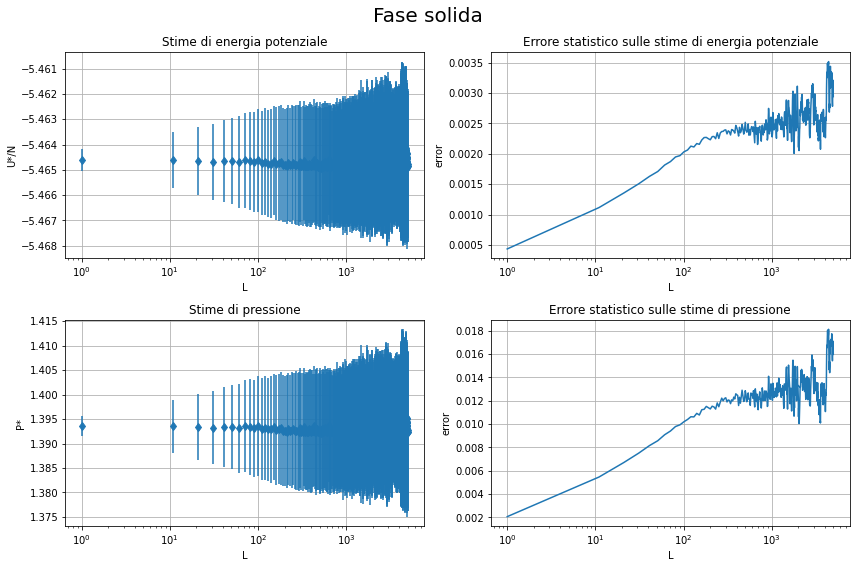

In [16]:
fig, plots = plt.subplots(2,2)
fig.set_size_inches(12, 8)

sub_tit_part = ['energia potenziale', 'pressione']
for i in range(0, 2):
    plots[i][0].set(xlabel='L', ylabel=labely[i])
    plots[i][0].grid()
    plots[i][0].errorbar(list_of_L, ris_liq[i]['means'], ris_liq[i]['errs'], fmt='d')
    plots[i][0].set_xscale('log')
    plots[i][0].set_title('Stime di ' + sub_tit_part[i])
    plots[i][1].set(xlabel='L', ylabel='error')
    plots[i][1].grid()
    plots[i][1].set_xscale('log')
    plots[i][1].plot(list_of_L, ris_liq[i]['errs'])
    plots[i][1].set_title('Errore statistico sulle stime di ' + sub_tit_part[i])
    
plt.suptitle('Fase solida', fontsize='20')
plt.tight_layout()
plt.show()

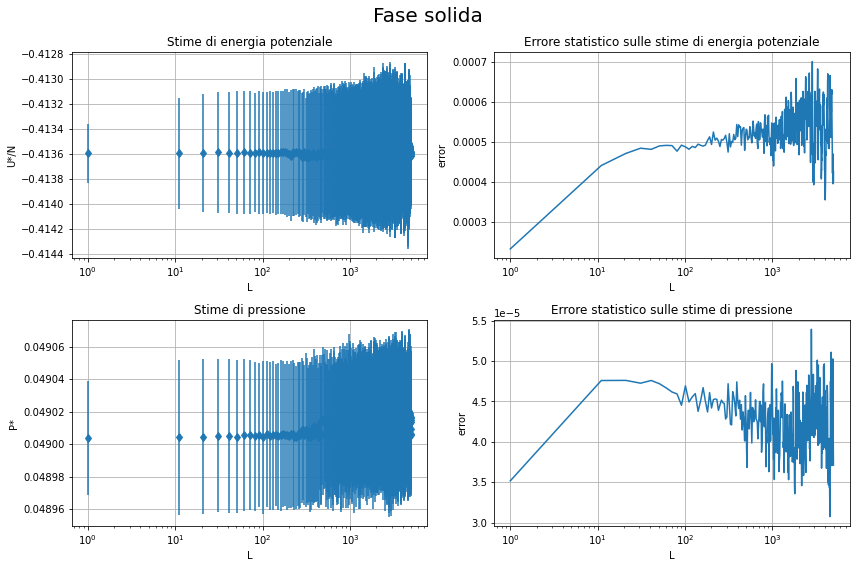

In [17]:
fig, plots = plt.subplots(2,2)
fig.set_size_inches(12, 8)

sub_tit_part = ['energia potenziale', 'pressione']
for i in range(0, 2):
    plots[i][0].set(xlabel='L', ylabel=labely[i])
    plots[i][0].grid()
    plots[i][0].errorbar(list_of_L, ris_gas[i]['means'], ris_gas[i]['errs'], fmt='d')
    plots[i][0].set_xscale('log')
    plots[i][0].set_title('Stime di ' + sub_tit_part[i])
    plots[i][1].set(xlabel='L', ylabel='error')
    plots[i][1].grid()
    plots[i][1].set_xscale('log')
    plots[i][1].plot(list_of_L, ris_gas[i]['errs'])
    plots[i][1].set_title('Errore statistico sulle stime di ' + sub_tit_part[i])
    
plt.suptitle('Fase solida', fontsize='20')
plt.tight_layout()
plt.show()

In tutte le situazioni esposte l'incertezza statistica ottenuta risulta più bassa con l'utilizzo di blocchi di basse dimensioni. Da valori di L pari circa a 100 i valori di incertezza si stabilizzano intorno a valori fissi. In alcuni casi si notano però forti fluttuazioni che si riescono a ridurre aumentando il numero complessivo di misure.

Questi dati suggeriscono che blocchi di piccole dimensioni forniscono stime sottovalutate dell'incertezza statistica. Anche questo risultato è in accordo sul prescrivere blocchi di dimensioni superiore a qualche centinaio di step.

Nelle successive simulazioni vengono utilizzati 10 blocchi da 5000 step ciascuno.

## 8 Risultati

I risultati delle simulazioni equilibrate sono i seguenti. Le condizioni termodinamiche dei 3 sistemi simulati sono, in unità SI

- fase solida: $\rho = (1.857 \cdot 10^3) $kg/m$^3$, $T = 96$K 
- fase liquida: $\rho = (1.350 \cdot 10^3) $kg/m$^3$, $T = 132$K 
- fase gassosa: $\rho = (0.844 \cdot 10^3) $kg/m$^3$, $T = 144$K

Avendo posto $\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K e $m=39.948$ amu

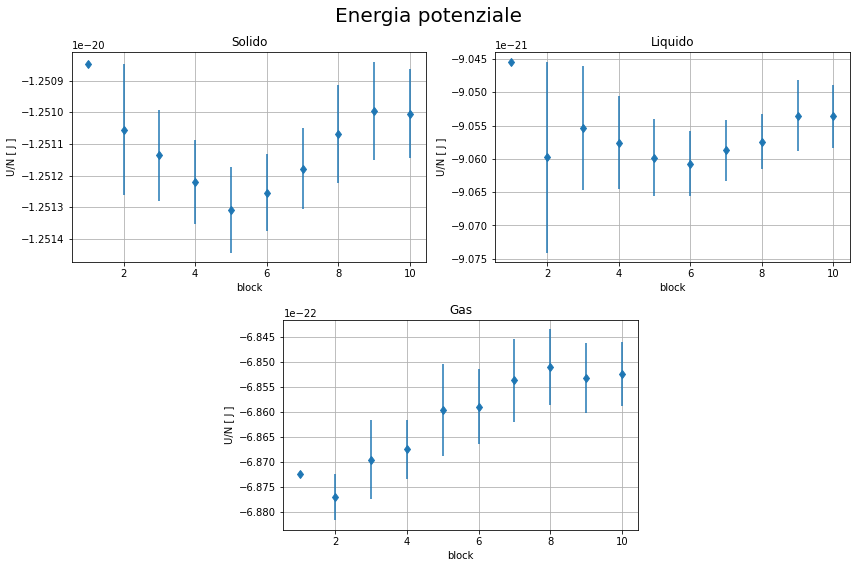

Stime finali ottenute
Solido	: (-1.2510 ± 0.0001) · 10^(-20) J
Liquido	: (-0.9054 ± 0.0005) · 10^(-20) J
Gas	: (-0.0685 ± 0.0001) · 10^(-20) J


In [18]:
import matplotlib.gridspec as gridspec

titles = ['Solido', 'Liquido', 'Gas']
files = ['../07/MonteCarlo_NVT/SolidGdR/output.epot.0', '../07/MonteCarlo_NVT/LiquidGdR/output.epot.0', '../07/MonteCarlo_NVT/GasGdR/output.epot.0']
    
#fig, plots = plt.subplots(2,2)
gs = gridspec.GridSpec(2,4)
fig = plt.figure()
plots = [plt.subplot(gs[0,0:2]), plt.subplot(gs[0,2:4]), plt.subplot(gs[1,1:3])]
fig.set_size_inches(12, 8)
#plots = plots.flatten()
finals = [0,0,0]
for i  in range(0, len(titles)):
    r, val, err = np.genfromtxt(files[i], usecols=(0,2,3), unpack=True)
    plots[i].errorbar(r, CUtoSI_energy(val), CUtoSI_energy(err), fmt='d')
    plots[i].set_title(titles[i])
    plots[i].set_xlabel('block')
    plots[i].set_ylabel('U/N [ J ]')
    plots[i].grid()
    finals[i] = (CUtoSI_energy(val[-1]), CUtoSI_energy(err[-1]))
    
plt.suptitle('Energia potenziale', fontsize='20')
plt.tight_layout()
plt.show()

print('Stime finali ottenute')
for i in range(len(titles)):
    print(titles[i] + '\t: ({:.4f} ± {:.4f}) · 10^(-20) J'.format(finals[i][0]*1e20, finals[i][1]*1e20))

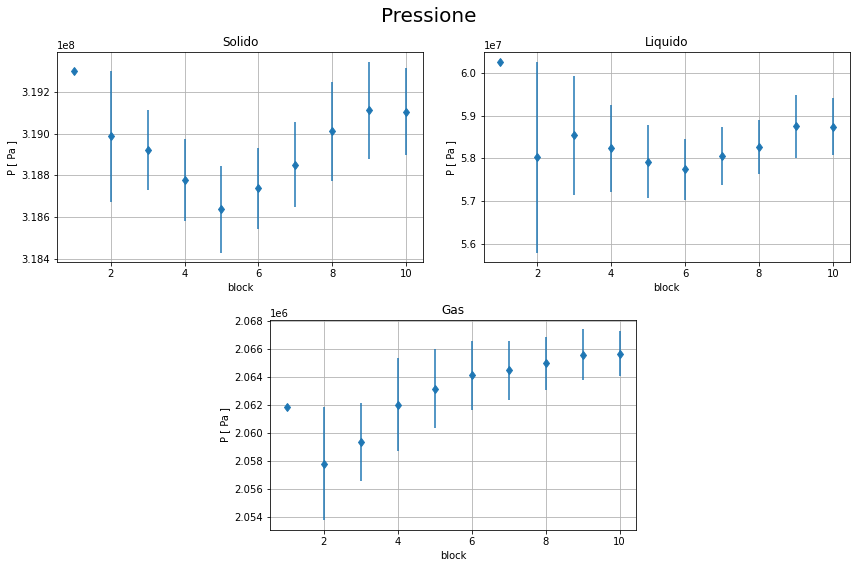

Stime finali ottenute
Solido	: (3.19105e+08 ± 2.08e+05) Pa
Liquido	: (5.87439e+07 ± 6.60e+05) Pa
Gas	: (2.06566e+06 ± 1.61e+03) Pa


In [19]:
import matplotlib.gridspec as grid

files = ['../07/MonteCarlo_NVT/SolidGdR/output.pres.0', '../07/MonteCarlo_NVT/LiquidGdR/output.pres.0', '../07/MonteCarlo_NVT/GasGdR/output.pres.0']
gs = grid.GridSpec(2,4)
fig = plt.figure()
plots = [plt.subplot(gs[0,0:2]), plt.subplot(gs[0,2:4]), plt.subplot(gs[1,1:3])]
fig.set_size_inches(12, 8)
#plots = plots.flatten()

for i  in range(0, len(titles)):
    r, val, err = np.genfromtxt(files[i], usecols=(0,2,3), unpack=True)
    plots[i].errorbar(r, CUtoSI_pressure(val), CUtoSI_pressure(err), fmt='d')
    plots[i].set_title(titles[i])
    plots[i].set_xlabel('block')
    plots[i].set_ylabel('P [ Pa ]')
    plots[i].grid()
    finals[i] = (CUtoSI_pressure(val[-1]), CUtoSI_pressure(err[-1]))
                      
plt.suptitle('Pressione', fontsize='20')
plt.tight_layout()
plt.show()

print('Stime finali ottenute')
for i in range(len(titles)):
    print(titles[i] + '\t: ({:.5e} ± {:.2e}) Pa'.format(finals[i][0], finals[i][1]))

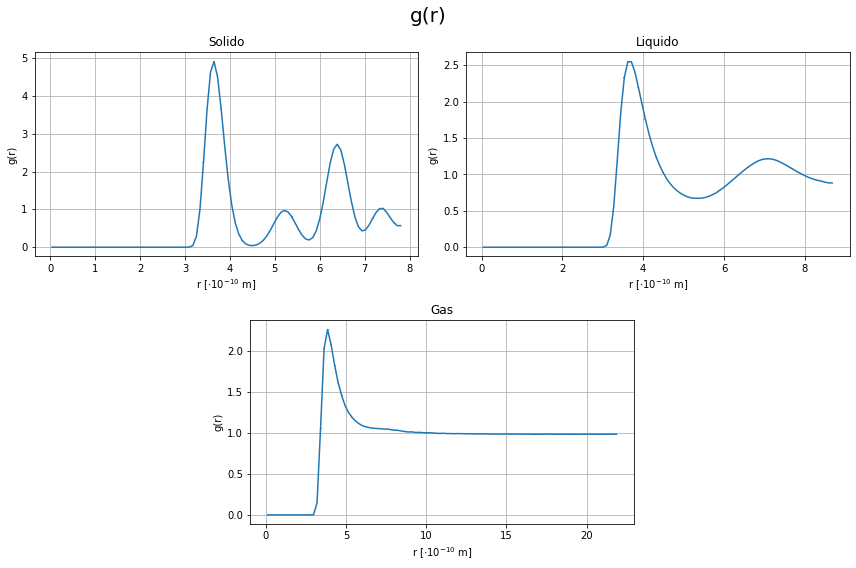

In [20]:
titles = ['Solido', 'Liquido', 'Gas']
files = ['../07/MonteCarlo_NVT/SolidGdR/output.gave.0', '../07/MonteCarlo_NVT/LiquidGdR/output.gave.0', '../07/MonteCarlo_NVT/GasGdR/output.gave.0']

#fig, plots = plt.subplots(2,2)
gs = gridspec.GridSpec(2,4)
fig = plt.figure()
plots = [plt.subplot(gs[0,0:2]), plt.subplot(gs[0,2:4]), plt.subplot(gs[1,1:3])]
fig.set_size_inches(12, 8)
#plots = plots.flatten()

for i  in range(0, len(titles)):
    r, gdir, err = np.genfromtxt(files[i], usecols=(0,1,2), unpack=True)
    plots[i].errorbar(CUtoSI_length(r)*1e10, gdir, err)
    plots[i].set_title(titles[i])
    plots[i].set_xlabel('r [$\cdot 10^{-10}$ m]')
    plots[i].set_ylabel('g(r)')
    plots[i].grid()
    
plt.suptitle('g(r)', fontsize='20')
plt.tight_layout()
plt.show()

In questi ultimi grafici è interessante notare i picchi della g(r). Nel caso del solido in particolare questi possono essere ricondotti alla struttura cristallina fornendo una misura della distanza dei primi vicini, secondi vicini, ecc.. .

La diminuzione del numero di picchi negli altri stati fornisce una indicazione sull'aumento del disordine del sistema. La g(r) del gas tende, per valori di r superiori a quello in cui si osserva un massimo, a 1. Questo indica che il sistema, a queste distanze, è analogo ad un sistema di uguale densità in cui le particelle siano distribuite casualmente.

## 9 Confronto con i risultati ottenuti nell'esercitazione 4 con l'algoritmo di Verlet

Ho infine aggiunto al codice realizzato in occasione della esercitazione 4, il calcolo della pressione e della funzione di distribuzione radiale.
In seguito è riportato il confronto tra i risultati ottenuti con i due metodi. I sitemi simulati sono analoghi a quelli del punto precedente.

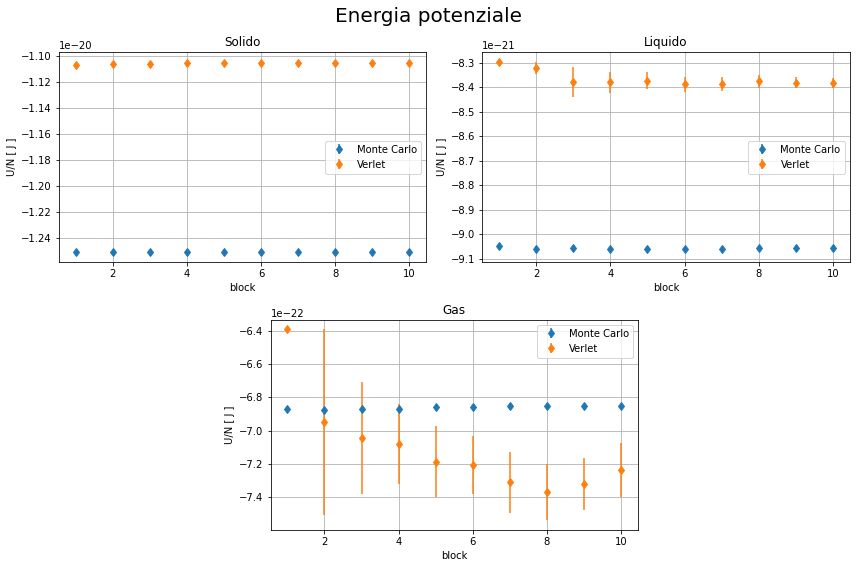

Stime finali ottenute
Solido
Monte Carlo: 	: (-1.25100e-20 ± 1.40e-24) Pa
Verlet: 	: (-1.10554e-20 ± 2.64e-24) Pa 

Liquido
Monte Carlo: 	: (-9.05363e-21 ± 4.76e-24) Pa
Verlet: 	: (-8.38376e-21 ± 2.07e-23) Pa 

Gas
Monte Carlo: 	: (-6.85235e-22 ± 6.35e-25) Pa
Verlet: 	: (-7.23847e-22 ± 1.64e-23) Pa 



In [21]:
titles = ['Solido', 'Liquido', 'Gas']
files = ['../07/MonteCarlo_NVT/SolidGdR/output.epot.0', '../07/MonteCarlo_NVT/LiquidGdR/output.epot.0', '../07/MonteCarlo_NVT/GasGdR/output.epot.0']
files_verlet = ['../04/MolecularDynamics_NVE/ioArSolid/output_epot_bm.dat', '../04/MolecularDynamics_NVE/ioArLiquid/output_epot_bm.dat', '../04/MolecularDynamics_NVE/ioArGas/output_epot_bm.dat']
    
gs = gridspec.GridSpec(2,4)
fig = plt.figure()
plots = [plt.subplot(gs[0,0:2]), plt.subplot(gs[0,2:4]), plt.subplot(gs[1,1:3])]
fig.set_size_inches(12, 8)
finals_v = [0,0,0]
#plots = plots.flatten()
finals = [0,0,0]
for i  in range(0, len(titles)):
    r, val, err = np.genfromtxt(files[i], usecols=(0,2,3), unpack=True)
    r_v, val_v, err_v = np.genfromtxt(files_verlet[i], usecols=(0,2,3), unpack=True)
    plots[i].errorbar(r, CUtoSI_energy(val), CUtoSI_energy(err), fmt='d', label='Monte Carlo')
    plots[i].set_title(titles[i])
    plots[i].set_xlabel('block')
    plots[i].set_ylabel('U/N [ J ]')
    plots[i].errorbar(r_v, CUtoSI_energy(val_v), CUtoSI_energy(err_v), fmt='d', label='Verlet')
    plots[i].grid()
    plots[i].legend()
    finals[i] = (CUtoSI_energy(val[-1]), CUtoSI_energy(err[-1]))
    finals_v[i] = (CUtoSI_energy(val_v[-1]), CUtoSI_energy(err_v[-1]))
    
plt.suptitle("Energia potenziale", fontsize='20')
plt.tight_layout()
plt.show()

print('Stime finali ottenute')
for i in range(len(titles)):
    print(titles[i])
    print('Monte Carlo: \t: ({:.5e} ± {:.2e}) Pa'.format(finals[i][0], finals[i][1]))
    print('Verlet: \t: ({:.5e} ± {:.2e}) Pa \n'.format(finals_v[i][0], finals_v[i][1]))

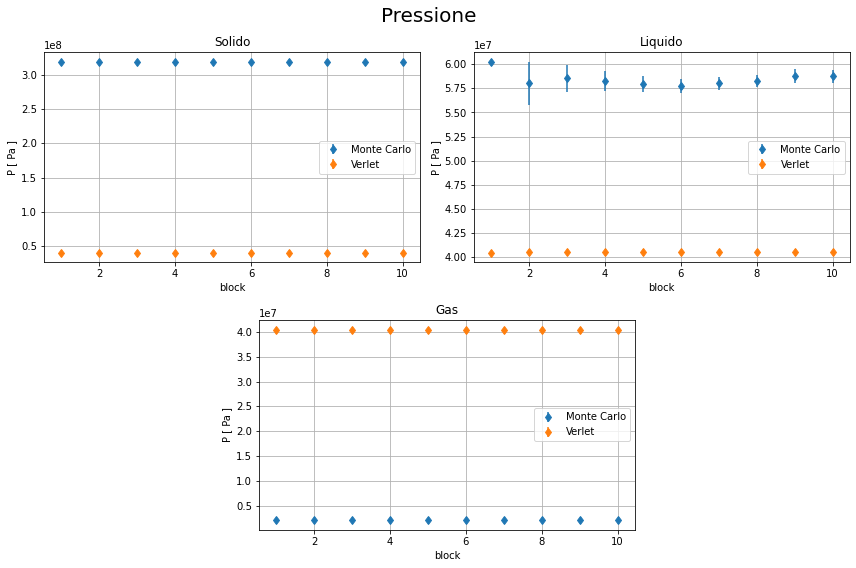

Stime finali ottenute
Solido
Monte Carlo: 	: (3.19105e+08 ± 2.08e+05) Pa
Verlet: 	: (4.04793e+07 ± 3.53e+03) Pa 

Liquido
Monte Carlo: 	: (5.87439e+07 ± 6.60e+05) Pa
Verlet: 	: (4.04793e+07 ± 3.53e+03) Pa 

Gas
Monte Carlo: 	: (2.06566e+06 ± 1.61e+03) Pa
Verlet: 	: (4.04793e+07 ± 3.53e+03) Pa 



In [22]:
files = ['../07/MonteCarlo_NVT/SolidGdR/output.pres.0', '../07/MonteCarlo_NVT/LiquidGdR/output.pres.0', '../07/MonteCarlo_NVT/GasGdR/output.pres.0']
files_verlet = ['../04/MolecularDynamics_NVE/ioArSolid/output_pres_bm.dat', '../04/MolecularDynamics_NVE/ioArSolid/output_pres_bm.dat', '../04/MolecularDynamics_NVE/ioArSolid/output_pres_bm.dat']
#fig, plots = plt.subplots(2,2)
gs = grid.GridSpec(2,4)
fig = plt.figure()
plots = [plt.subplot(gs[0,0:2]), plt.subplot(gs[0,2:4]), plt.subplot(gs[1,1:3])]
fig.set_size_inches(12, 8)
#plots = plots.flatten()

for i  in range(0, len(titles)):
    r, val, err = np.genfromtxt(files[i], usecols=(0,2,3), unpack=True)
    r_v, val_v, err_v = np.genfromtxt(files_verlet[i], usecols=(0,2,3), unpack=True)
    plots[i].errorbar(r, CUtoSI_pressure(val), CUtoSI_pressure(err), fmt='d', label='Monte Carlo')
    plots[i].set_title(titles[i])
    plots[i].set_xlabel('block')
    plots[i].set_ylabel('P [ Pa ]')
    plots[i].grid()
    plots[i].errorbar(r_v, CUtoSI_pressure(val_v), CUtoSI_pressure(err_v), fmt='d', label='Verlet')
    plots[i].legend()
    finals[i] = (CUtoSI_pressure(val[-1]), CUtoSI_pressure(err[-1]))
    finals_v[i] = (CUtoSI_pressure(val_v[-1]), CUtoSI_pressure(err_v[-1]))
    
plt.suptitle('Pressione', fontsize='20')
plt.tight_layout()
plt.show()

print('Stime finali ottenute')
for i in range(len(titles)):
    print(titles[i])
    print('Monte Carlo: \t: ({:.5e} ± {:.2e}) Pa'.format(finals[i][0], finals[i][1]))
    print('Verlet: \t: ({:.5e} ± {:.2e}) Pa \n'.format(finals_v[i][0], finals_v[i][1]))

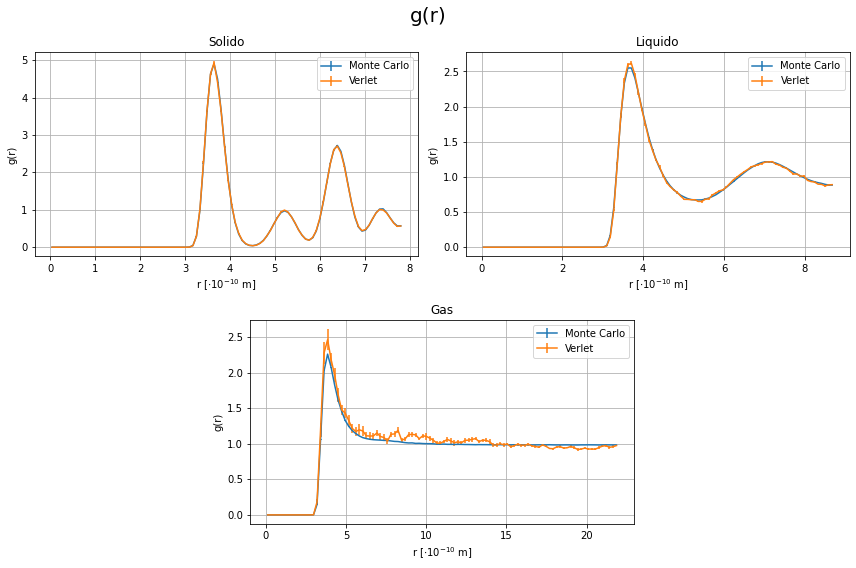

In [23]:
titles = ['Solido', 'Liquido', 'Gas']
files = ['../07/MonteCarlo_NVT/SolidGdR/output.gave.0', '../07/MonteCarlo_NVT/LiquidGdR/output.gave.0', '../07/MonteCarlo_NVT/GasGdR/output.gave.0']
files_verlet = ['../04/MolecularDynamics_NVE/ioArSolid/output_gdir_final.dat', '../04/MolecularDynamics_NVE/ioArLiquid/output_gdir_final.dat', '../04/MolecularDynamics_NVE/ioArGas/output_gdir_final.dat']

#fig, plots = plt.subplots(2,2)
gs = gridspec.GridSpec(2,4)
fig = plt.figure()
plots = [plt.subplot(gs[0,0:2]), plt.subplot(gs[0,2:4]), plt.subplot(gs[1,1:3])]
fig.set_size_inches(12, 8)
#plots = plots.flatten()

for i  in range(0, len(titles)):
    r, gdir, err = np.genfromtxt(files[i], usecols=(0,1,2), unpack=True)
    r_v, gdir_v, err_v = np.genfromtxt(files_verlet[i], usecols=(0,1,2), unpack=True)
    plots[i].errorbar(CUtoSI_length(r)*1e10, gdir, err, label='Monte Carlo')
    plots[i].errorbar(CUtoSI_length(r_v)*1e10, gdir_v, err_v, label='Verlet')
    plots[i].set_title(titles[i])
    plots[i].set_xlabel('r [$\cdot 10^{-10}$ m]')
    plots[i].set_ylabel('g(r)')
    plots[i].grid()
    plots[i].legend()
    
plt.suptitle('g(r)', fontsize='20')
plt.tight_layout()
plt.show()

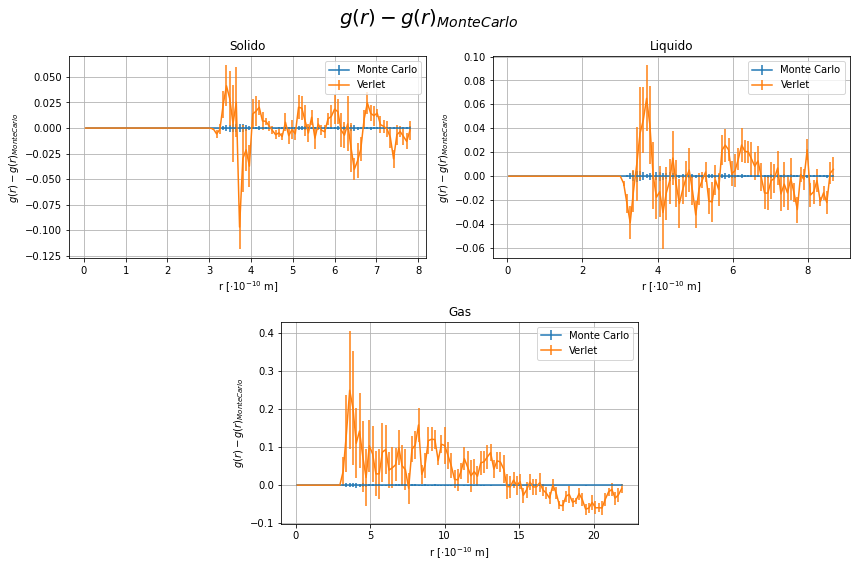

In [24]:
titles = ['Solido', 'Liquido', 'Gas']
files = ['../07/MonteCarlo_NVT/SolidGdR/output.gave.0', '../07/MonteCarlo_NVT/LiquidGdR/output.gave.0', '../07/MonteCarlo_NVT/GasGdR/output.gave.0']
files_verlet = ['../04/MolecularDynamics_NVE/ioArSolid/output_gdir_final.dat', '../04/MolecularDynamics_NVE/ioArLiquid/output_gdir_final.dat', '../04/MolecularDynamics_NVE/ioArGas/output_gdir_final.dat']

#fig, plots = plt.subplots(2,2)
gs = gridspec.GridSpec(2,4)
fig = plt.figure()
plots = [plt.subplot(gs[0,0:2]), plt.subplot(gs[0,2:4]), plt.subplot(gs[1,1:3])]
fig.set_size_inches(12, 8)
#plots = plots.flatten()

for i  in range(0, len(titles)):
    r, gdir, err = np.genfromtxt(files[i], usecols=(0,1,2), unpack=True)
    r_v, gdir_v, err_v = np.genfromtxt(files_verlet[i], usecols=(0,1,2), unpack=True)
    plots[i].errorbar(CUtoSI_length(r)*1e10, 0*r, err, label='Monte Carlo')
    plots[i].errorbar(CUtoSI_length(r_v)*1e10, gdir_v-gdir, err_v, label='Verlet')
    plots[i].set_title(titles[i])
    plots[i].set_xlabel('r [$\cdot 10^{-10}$ m]')
    plots[i].set_ylabel('$g(r)-g(r)_{Monte Carlo}$')
    plots[i].grid()
    plots[i].legend()
    
plt.suptitle('$g(r)-g(r)_{Monte Carlo}$', fontsize='20')
plt.tight_layout()
plt.show()

Come si può osservare i valori di energia potenziale e pressione non risultano compatibili entro le rispettive incertezze statistiche. Tuttavia si deve considerare che le condizioni termodinamiche, in particolare la temperatura, sono state un parametro difficile da impostare nella simulazione che utilizza l'algoritmo di Verlet. Le temperature simulate sono infatti leggermente diverse da quelle target. 
Parte della discrepanza tra i valori ottenuti potrebbe essere quindi dovuta a questo aspetto. Inoltre in queste simulazioni, realizzate col metodo Monte Carlo, è stata anche aggiunta alle misure di energia potenziale e pressione la correzione di coda. Questa costituisce un'altra possibile spiegazione della differenza tra i valori ottenuti.

Le funzioni di distribuzione radiale sono invece risultate per lo più compatibili entro le rispettive incertezze.